In [1]:
# Import all necessary packages

import requests
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from numpy import mean
import pickle
import sklearn.linear_model as lm
import sklearn.ensemble as se
from sklearn import svm
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

C:\Users\jpgra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Define all functions used in this notebook, to keep later code clean and easier to follow


# Access api, and then build DataFrame from cleaned json_data received
def get_data(url):   

    response = requests.get(url)
    json_data = json.loads(response.text)

    df = pd.DataFrame(json_data)
    df.set_index('crash_id', inplace=True)

    return df


# Made a judgment call here. Since our dataset was composed of over 250,000 entries (way too many to feasibly
# include in a model with our tools), rather than imputing any of our missing value with various strategies, we
# decided to just drop rows with missing values (around 8,000 entries). We also separated the 'crash_datetime' 
# column into 4 distinct columns as shown below, in order to see the effect of each component in our model. 
# With multicollinearity in mind, we decided to drop 'route', 'milepoint', and 'main_road_name' from our model. 
# While valuable data points for the police force to keep track of, these different features were tied very closely 
# to the geospatial characteristics of 'lat_utm_y' and 'long_utm_x'. 
# Lastly, we converted 'lat_utm_y', 'long_utm_x', and our label 'crash_severity_id' to numeric values in order to 
# keep them from becoming dummy variables in our next step (they were stored as strings in the dataset).
def clean_data(df) :

    df.dropna(inplace=True)
    df['year'] = ''
    df['month'] = ''
    df['day'] = ''
    df['hour'] = ''
    for i in tqdm(range(len(df))) :
        df.iloc[i,28] = df.iloc[i,0][:4]
        df.iloc[i,29] = df.iloc[i,0][5:7]
        df.iloc[i,30] = df.iloc[i,0][8:10]
        if int(df.iloc[i,0][14:16]) < 30 :
            df.iloc[i,31] = df.iloc[i,0][11:13]
        else :
            df.iloc[i,31] = int(df.iloc[i,0][11:13]) + 1

    df.drop('crash_datetime', 1, inplace=True)
    df.drop('route', 1, inplace=True)
    df.drop('milepoint', 1, inplace=True)
    df.drop('main_road_name', 1, inplace=True)
    df['lat_utm_y'] = pd.to_numeric(df['lat_utm_y'])
    df['long_utm_x'] = pd.to_numeric(df['long_utm_x'])
    df['crash_severity_id'] = pd.to_numeric(df['crash_severity_id'])

    return df


# Make dummy variables for every non-numeric feature
def make_dummies(df) :
    for col in tqdm(df):
        if not pd.api.types.is_numeric_dtype(df[col]):
          df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)
    
    return df


# A feature selection tool to help determine the most statistically significant features
def fs_variance(df, label="", p=0.8):

    if label != "":
        X = df.drop(columns=[label])
    
    sel = VarianceThreshold(threshold=(p * (1 - p)))
    sel.fit_transform(X)

    # Add the label back in after removing poor features
    return df[sel.get_feature_names_out()].join(df[label])


# Another feature selection tool
def fs_kbest(df, k=10, label=""):
    
    X = df.drop(columns=[label])
    y = df[label]
    
    # Select the top k features based on a given bivariate metric
    sel = SelectKBest(r_regression, k=k)
    sel.fit_transform(X, y)
    
    return df[sel.get_feature_names_out()].join(df[label])


# And another feature selection tool
def fs_select_linear(df, label=""):
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    import pandas as pd

    X = df.drop(label,axis=1)
    y = df[label]

    # As C increases, more features are kept
    lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X, y)
    sel = SelectFromModel(lsvc, prefit=True)
    sel.transform(X)

    columns = list(X.columns[sel.get_support()])
    columns.append(label)
    return df[columns]


# Helps determine whether our features have multicollinearity. This singles 
# out features that could be hurting our model because of interdependence
def vif(df, label=""):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # drop unnecessary columns if they are found in the dataframe
    if label in df.columns: df.drop(columns=[label], inplace=True)
    if 'const' in df.columns: df.drop(columns=['const'], inplace=True)

    # form input data for each exogenous variable
    for col in df:
        y = df[col]
        X = df.drop(columns=[col])

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        if r_squared < 1: # Prevent division by zero runtime error
            vif = 1/(1 - r_squared) 
        else:
            vif = 100
        vif_dict[col] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[col] = tolerance

    # generate the DataFrame to return
    return pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict}).sort_values(by=['VIF'], ascending=False)


# As stated above, we chose to build a Classification model. We made this
# decision because we wanted to analyze our label as a categorical variable. 
# Before we made that decision, though, we tried running several regression
# models. This is the pipeline we used (along with the OLS model)
def fit_crossvalidate_reg(df, label, k=10, r=5, repeat=True):

    X = df.drop(columns=[label])
    y = df[label]

    if repeat:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
    else:
        cv = KFold(n_splits=k, random_state=12345, shuffle=True)
    
    fit = {}    # Use this to store each of the fit metrics
    models = {} # Use this to store each of the models

    # Create the model objects
    model_ols = lm.LinearRegression()
    model_rr = lm.Ridge(alpha=0.5) # adjust this alpha parameter for better results (between 0 and 1)
    model_lr = lm.Lasso(alpha=0.1) # adjust this alpha parameter for better results (between 0 and 1)
    model_llr = lm.LassoLars(alpha=0.1) # adjust this alpha parameter for better results (between 0 and 1)
    model_br = lm.BayesianRidge()
    model_pr = lm.TweedieRegressor(power=1, link="log") # Power=1 means this is a Poisson
    model_gr = lm.TweedieRegressor(power=2, link="log") # Power=2 means this is a Gamma
    model_igr = lm.TweedieRegressor(power=3) # Power=3 means this is an inverse Gamma
    model_svm = svm.SVR()
    model_lsvm = svm.LinearSVR()
    model_nusvm = svm.NuSVR()
    model_gpr = gaussian_process.GaussianProcessRegressor(DotProduct() + WhiteKernel())
    model_df = se.RandomForestRegressor(random_state=12345)
    model_etr = se.ExtraTreesRegressor(random_state=12345)
    model_abr = se.AdaBoostRegressor(n_estimators=100, random_state=12345)
    model_gbr = se.GradientBoostingRegressor(random_state=12345)
    model_hgbr = se.HistGradientBoostingRegressor(random_state=12345)
    model_vr = se.VotingRegressor(estimators=[('DF', model_df), ('ETR', model_etr), ('ABR', model_abr), ('GBR', model_gbr)])
    estimators = [('ridge', lm.RidgeCV()), ('lasso', lm.LassoCV(random_state=42)), ('svr', svm.SVR(C=1, gamma=1e-6))]
    model_sr = se.StackingRegressor(estimators=estimators, final_estimator=se.GradientBoostingRegressor(random_state=12345))
    model_xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    
    # Fit a crss-validated R squared score and add it to the dict
    fit['OLS'] = mean(cross_val_score(model_ols, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Ridge'] = mean(cross_val_score(model_rr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Lasso'] = mean(cross_val_score(model_lr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['LARS'] = mean(cross_val_score(model_llr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Bayesian'] = mean(cross_val_score(model_br, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Poisson'] = mean(cross_val_score(model_pr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Gamma'] = mean(cross_val_score(model_gr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Inverse'] = mean(cross_val_score(model_igr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['SupportVM'] = mean(cross_val_score(model_svm, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Linear SVM'] = mean(cross_val_score(model_lsvm, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['NuSupportVM'] = mean(cross_val_score(model_nusvm, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['GaussianP'] = mean(cross_val_score(model_gpr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Dec Forest'] = mean(cross_val_score(model_df, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Extra Trees'] = mean(cross_val_score(model_etr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['AdaBoost DT'] = mean(cross_val_score(model_abr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Grad. Boost'] = mean(cross_val_score(model_gbr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['HG Boost'] = mean(cross_val_score(model_hgbr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Voting'] = mean(cross_val_score(model_vr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['Stacking'] = mean(cross_val_score(model_sr, X, y, scoring='r2', cv=cv, n_jobs=-1))
    fit['XGBoost'] = mean(cross_val_score(model_xgb, X, y, scoring='r2', cv=cv, n_jobs=-1))

    # Add the model to another dict; make sure the keys have the same names as the list above
    models['OLS'] = model_ols
    models['Ridge'] = model_rr
    models['Lasso'] = model_lr
    models['LARS'] = model_llr
    models['Bayesian'] = model_br
    models['Poisson'] = model_pr
    models['Gamma'] = model_gr
    models['Inverse'] = model_igr
    models['SupportVM'] = model_svm
    models['Linear SVM'] = model_lsvm
    models['NuSupportVM'] = model_nusvm
    models['GaussianP'] = model_gpr
    models['Dec Forest'] = model_df
    models['Extra Trees'] = model_etr
    models['AdaBoost DT'] = model_abr
    models['Grad. Boost'] = model_gbr
    models['HG Boost'] = model_hgbr
    models['Voting'] = model_vr
    models['Stacking'] = model_sr
    models['XGBoost'] = model_xgb

    # Add the fit dictionary to a new DataFrame, sort, extract the top row, 
    # use it to retrieve the model object from the models dictionary
    df_fit = pd.DataFrame({'R-squared':fit})
    df_fit.sort_values(by=['R-squared'], ascending=False, inplace=True)
    best_model = df_fit.index[0]
    print(df_fit)

    return models[best_model].fit(X, y)


# Here, we have the Classification equivalent of the above pipeline. 
# This eventually evaluated that a Logistic Classification model would provide 
# the most accurate results for us (~72% accuracy)
def fit_crossvalidate_clf(df, label, k=10, r=5, repeat=True):
    import sklearn.linear_model as lm, pandas as pd, sklearn.ensemble as se, numpy as np
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    from numpy import mean, std
    from sklearn import svm
    from sklearn import gaussian_process
    from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    from sklearn import svm
    from sklearn.naive_bayes import CategoricalNB
    from xgboost import XGBClassifier
    from sklearn import preprocessing
    from sklearn.neural_network import MLPClassifier
    
    X = df.drop(columns=[label])
    y = df[label]
    
    if repeat:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
    else:
        cv = KFold(n_splits=k, random_state=12345, shuffle=True)
    
    fit = {}    # Use this to store each of the fit metrics
    models = {} # Use this to store each of the models
    
    # Create the model objects
    model_log = lm.LogisticRegression(max_iter=100)
    model_logcv = lm.RidgeClassifier()
    model_sgd = lm.SGDClassifier(max_iter=1000, tol=1e-3)
    model_pa = lm.PassiveAggressiveClassifier(max_iter=1000, random_state=12345, tol=1e-3)
    model_per = lm.Perceptron(fit_intercept=False, max_iter=10, tol=None, shuffle=False)
    model_knn = KNeighborsClassifier(n_neighbors=3)
    model_svm = svm.SVC(decision_function_shape='ovo') # Remove the parameter for two-class model
    model_nb = CategoricalNB()
    model_bag = se.BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
    model_ada = se.AdaBoostClassifier(n_estimators=100, random_state=12345)
    model_ext = se.ExtraTreesClassifier(n_estimators=100, random_state=12345)
    model_rf = se.RandomForestClassifier(n_estimators=10)
    model_hgb = se.HistGradientBoostingClassifier(max_iter=100)
    model_vot = se.VotingClassifier(estimators=[('lr', model_log), ('rf', model_ext), ('gnb', model_hgb)], voting='hard')
    model_gb = se.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    estimators = [('ridge', lm.RidgeCV()), ('lasso', lm.LassoCV(random_state=12345)), ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean'))]
    final_estimator = se.GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=12345)
    model_st = se.StackingRegressor(estimators=estimators, final_estimator=final_estimator)
    model_xgb = XGBClassifier()
    model_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=12345)
    
    # Fit a cross-validated R squared score and add it to the dict
    fit['Logistic'] = mean(cross_val_score(model_log, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Ridge'] = mean(cross_val_score(model_logcv, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['SGD'] = mean(cross_val_score(model_sgd, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['PassiveAggressive'] = mean(cross_val_score(model_pa, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Perceptron'] = mean(cross_val_score(model_per, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['KNN'] = mean(cross_val_score(model_knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['SVM'] = mean(cross_val_score(model_svm, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['NaiveBayes'] = mean(cross_val_score(model_nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Bagging'] = mean(cross_val_score(model_bag, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['AdaBoost'] = mean(cross_val_score(model_ada, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['ExtraTrees'] = mean(cross_val_score(model_ext, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['RandomForest'] = mean(cross_val_score(model_rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['HistGradient'] = mean(cross_val_score(model_hgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Voting'] = mean(cross_val_score(model_vot, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['GradBoost'] = mean(cross_val_score(model_gb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['XGBoost'] = mean(cross_val_score(model_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['NeuralN'] = mean(cross_val_score(model_nn, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    
    # Add the model to another dictionary; make sure the keys have the same names as the list above
    models['Logistic'] = model_log
    models['Ridge'] = model_logcv
    models['SGD'] = model_sgd
    models['PassiveAggressive'] = model_pa
    models['Perceptron'] = model_per
    models['KNN'] = model_knn
    models['SVM'] = model_svm
    models['NaiveBayes'] = model_nb
    models['Bagging'] = model_bag
    models['AdaBoost'] = model_ada
    models['ExtraTrees'] = model_ext
    models['RandomForest'] = model_rf
    models['HistGradient'] = model_hgb
    models['Voting'] = model_vot
    models['GradBoost'] = model_gb
    models['XGBoost'] = model_xgb
    models['NeuralN'] = model_nn
    
    # Add the fit dictionary to a new DataFrame, sort, extract the top row, use it to retrieve the model object from the models dictionary
    df_fit = pd.DataFrame({'Accuracy':fit})
    df_fit.sort_values(by=['Accuracy'], ascending=False, inplace=True)
    best_model = df_fit.index[0]
    print(df_fit)
    
    return models[best_model].fit(X, y)


# For saving the model to a file
def dump_pickle(model, file_name):

    pickle.dump(model, open(file_name, "wb"))


#For later accessing said file
def load_pickle(file_name):

    model = pickle.load(open(file_name, "rb"))

    return model

In [ ]:
# From this point on, we begin actually accessing our functions and building our model.
# NOTE: Throughout these steps, we progressively move from df to df2 to df3, and on. This 
# was done to save time from having to run previously steps when overwriting a single df.
# The copies are intuitive, should be easy to follow.

In [3]:
# 1.) Build df
df = get_data("https://opendata.utah.gov/resource/herb-zqda.json?$limit=252500&$$app_token=8QVQRvHCZonZefrBAo3my67DF")
df

,crash_datetime,route,milepoint,lat_utm_y,long_utm_x,main_road_name,city,county_name,crash_severity_id,work_zone_related,...,domestic_animal_related,overturn_rollover,commercial_motor_veh_involved,teenage_driver_involved,older_driver_involved,night_dark_condition,single_vehicle,distracted_driving,drowsy_driving,roadway_departure
crash_id,,,,,,,,,,,,,,,,,,,,,
11281387,2019-02-08T10:56:00.000,2258,4.56,4513124.085,422620.0512,900 WEST,SALT LAKE CITY,SALT LAKE,2,False,...,False,False,True,False,False,False,False,False,False,True
11282089,2019-12-24T12:48:00.000,2082,2.702,4483700.743,427458.6694,1215 E HIGHLAND DR,DRAPER,SALT LAKE,1,False,...,False,False,False,True,False,False,False,False,False,False
11282092,2019-12-28T20:42:00.000,2062,0.351,4486609.366,426779.0152,1022 E DRAPER PKY,DRAPER,SALT LAKE,1,False,...,False,False,False,True,False,True,False,False,False,False
11282098,2019-12-07T00:46:00.000,2048,0.438,4484350.913,426397.6578,13463 S FORT ST,DRAPER,SALT LAKE,3,False,...,False,True,False,False,False,True,True,False,False,False
11282101,2019-12-18T17:29:00.000,2068,0.796,4485217.604,427714.0392,13043 S 1300 E,DRAPER,SALT LAKE,1,False,...,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11304083,2019-11-21T23:17:00.000,353484,0.1,4484305.829,412209.1538,6094 W CHAMPLAIN WY,HERRIMAN,SALT LAKE,1,False,...,False,False,False,False,False,True,False,False,False,True
11304174,2019-10-22T19:09:00.000,2068,1.464,4486291.662,427726.2553,1300 E CONSTITUTION AVE,DRAPER,SALT LAKE,2,False,...,False,False,False,False,False,False,True,False,False,False
11304628,2019-10-25T17:30:00.000,2033,0.998,4483292.486,425009.0526,14000 S BANGERTER PKY,DRAPER,SALT LAKE,3,False,...,False,False,False,False,False,False,True,False,False,False


In [4]:
# 2.) Clean df
df2 = clean_data(df)
df2

100%|██████████| 244248/244248 [00:54<00:00, 4477.12it/s]
C:\Users\jpgra\AppData\Local\Temp/ipykernel_9508/540191552.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('crash_datetime', 1, inplace=True)
C:\Users\jpgra\AppData\Local\Temp/ipykernel_9508/540191552.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('route', 1, inplace=True)
C:\Users\jpgra\AppData\Local\Temp/ipykernel_9508/540191552.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('milepoint', 1, inplace=True)
C:\Users\jpgra\AppData\Local\Temp/ipykernel_9508/540191552.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('main_road_name', 1

,lat_utm_y,long_utm_x,city,county_name,crash_severity_id,work_zone_related,pedestrian_involved,bicyclist_involved,motorcycle_involved,improper_restraint,...,older_driver_involved,night_dark_condition,single_vehicle,distracted_driving,drowsy_driving,roadway_departure,year,month,day,hour
crash_id,,,,,,,,,,,,,,,,,,,,,
11281387,4513124.085,422620.0512,SALT LAKE CITY,SALT LAKE,2,False,False,False,False,False,...,False,False,False,False,False,True,2019,02,08,11
11282089,4483700.743,427458.6694,DRAPER,SALT LAKE,1,False,False,False,False,False,...,False,False,False,False,False,False,2019,12,24,13
11282092,4486609.366,426779.0152,DRAPER,SALT LAKE,1,False,False,False,False,False,...,False,True,False,False,False,False,2019,12,28,21
11282098,4484350.913,426397.6578,DRAPER,SALT LAKE,3,False,False,False,False,False,...,False,True,True,False,False,False,2019,12,07,1
11282101,4485217.604,427714.0392,DRAPER,SALT LAKE,1,False,False,False,False,False,...,False,True,False,False,False,False,2019,12,18,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11304083,4484305.829,412209.1538,HERRIMAN,SALT LAKE,1,False,False,False,False,False,...,False,True,False,False,False,True,2019,11,21,23
11304174,4486291.662,427726.2553,DRAPER,SALT LAKE,2,False,False,True,False,False,...,False,False,True,False,False,False,2019,10,22,19
11304628,4483292.486,425009.0526,DRAPER,SALT LAKE,3,False,False,True,False,False,...,False,False,True,False,False,False,2019,10,25,18


In [8]:
# 3.) Double checked our types in our dataframe to make sure we had the right features
X = df2.select_dtypes(np.number)
X

,lat_utm_y,long_utm_x,crash_severity_id
crash_id,,,
11281387,4513124.085,422620.0512,2
11282089,4483700.743,427458.6694,1
11282092,4486609.366,426779.0152,1
11282098,4484350.913,426397.6578,3
11282101,4485217.604,427714.0392,1
...,...,...,...
11304083,4484305.829,412209.1538,1
11304174,4486291.662,427726.2553,2
11304628,4483292.486,425009.0526,3


In [5]:
#4.) Make dummy variables for non-numeric features
df3 = make_dummies(df2)

  0%|          | 28/244248 [00:08<20:31:02,  3.31it/s]


In [21]:
#5.) Initial feature selection. R^3 was .1925, just a bit shy of the linear one 
# at .1928 (ran code through modeling pipeline afterwords to monitor R^2). This one 
# runs significantly faster however so we pickin it
df_test = df3.copy()

df_test = fs_variance(df_test, "crash_severity_id", 0.999)
print(df_test.shape)

(244248, 247)


In [48]:
#6.) Tried various feature selection tests to see which would give best results (ran 
# code through modeling pipeline afterwords to monitor R^2). Not a winner.
df_test = df3.copy()

df_test = fs_kbest(df_test, 128, label="crash_severity_id")

In [27]:
#7.) Tried another feature selection test, not a winner (ran code through modeling 
# pipeline afterwords to monitor R^2).
df_test = df3.copy()

df_test = fs_select_linear(df_test, label="crash_severity_id")

C:\Users\jpgra\Desktop\455\assignment1\ml-venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jpgra\Desktop\455\assignment1\ml-venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [22]:
#8.) Before deciding on a classification model, ran through several iterations of this 
# OLS Regression to evaluate which features were statistically significant. Continued 
# this until all remaining features had a p-score under .05.

# Set label and features
y = df_test['crash_severity_id']
X = df_test.drop(columns=['crash_severity_id', 'city_BOUNTIFUL', 'city_BRIGHAM CITY', 'city_CENTERVILLE', 'city_LEHI', 'city_NEPHI', 'lat_utm_y', 'county_name_SAN JUAN', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06','day_07','day_08','day_09','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_22','day_21','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','hour_24','hour_00','hour_02','hour_05','hour_06','domestic_animal_related_True','county_name_WASHINGTON','city_PROVIDENCE','city_NORTH LOGAN','city_HYDE PARK','city_NORTH OGDEN','city_SOUTH WEBER','city_ST. GEORGE','county_name_IRON','county_name_JUAB','county_name_SALT LAKE','county_name_SEVIER','year_2018','hour_01','county_name_KANE','hour_03','year_2017','city_WELLSVILLE','city_UINTAH','city_GRANTSVILLE','city_MAGNA', 'city_FARR WEST','city_KEARNS','city_LINDON','city_PERRY','city_VERNAL','city_WEST BOUNTIFUL','county_name_DUCHESNE','county_name_UINTAH','long_utm_x','city_KAYSVILLE','county_name_SANPETE','county_name_MORGAN','county_name_CARBON','county_name_GRAND','city_HERRIMAN','city_WOODS CROSS','city_SALEM','city_DRAPER','city_MARRIOTT-SLATERVILLE','city_MURRAY','city_PAYSON','county_name_RICH','month_02','year_2019','month_12','hour_04','hour_07','hour_08','hour_09','month_03','month_04','month_05','month_06','month_07','month_08','month_09','month_10','month_11', 'night_dark_condition_True','county_name_CACHE','county_name_WEBER','city_WASHINGTON','city_SOUTH JORDAN','city_MIDVALE','city_MILLCREEK','city_CEDAR CITY','city_HOLLADAY','county_name_DAVIS','city_NORTH SALT LAKE','city_FRUIT HEIGHTS']).assign(const=1)


model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      crash_severity_id   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     842.0
Date:                Wed, 06 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:06:44   Log-Likelihood:            -2.5633e+05
No. Observations:              244248   AIC:                         5.128e+05
Df Residuals:                  244178   BIC:                         5.135e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
city

In [23]:
#9.) Removed these features from our df.

df_test = df_test.drop(columns=['city_BOUNTIFUL', 'city_BRIGHAM CITY', 'city_CENTERVILLE', 'city_LEHI', 'city_NEPHI', 'lat_utm_y', 'county_name_SAN JUAN', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06','day_07','day_08','day_09','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_22','day_21','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','hour_24','hour_00','hour_02','hour_05','hour_06','domestic_animal_related_True','county_name_WASHINGTON','city_PROVIDENCE','city_NORTH LOGAN','city_HYDE PARK','city_NORTH OGDEN','city_SOUTH WEBER','city_ST. GEORGE','county_name_IRON','county_name_JUAB','county_name_SALT LAKE','county_name_SEVIER','year_2018','hour_01','county_name_KANE','hour_03','year_2017','city_WELLSVILLE','city_UINTAH','city_GRANTSVILLE','city_MAGNA', 'city_FARR WEST','city_KEARNS','city_LINDON','city_PERRY','city_VERNAL','city_WEST BOUNTIFUL','county_name_DUCHESNE','county_name_UINTAH','long_utm_x','city_KAYSVILLE','county_name_SANPETE','county_name_MORGAN','county_name_CARBON','county_name_GRAND','city_HERRIMAN','city_WOODS CROSS','city_SALEM','city_DRAPER','city_MARRIOTT-SLATERVILLE','city_MURRAY','city_PAYSON','county_name_RICH','month_02','year_2019','month_12','hour_04','hour_07','hour_08','hour_09','month_03','month_04','month_05','month_06','month_07','month_08','month_09','month_10','month_11', 'night_dark_condition_True','county_name_CACHE','county_name_WEBER','city_WASHINGTON','city_SOUTH JORDAN','city_MIDVALE','city_MILLCREEK','city_CEDAR CITY','city_HOLLADAY','county_name_DAVIS','city_NORTH SALT LAKE','city_FRUIT HEIGHTS'])

In [24]:
#10.) Checked shape of our df. 70 columns! A much more manageable 
# number than our previous df (247 columns).

df_test.shape

(244248, 70)

In [63]:
#11.) Ran a vif test to check for multicollinearity. Almost 
# everything was under a score of 3, that's pretty good!

print(vif(df_test))

                               VIF  Tolerance
single_vehicle_True       3.712166   0.269384
county_name_UTAH          3.059843   0.326814
roadway_departure_True    2.837906   0.352372
wild_animal_related_True  1.791203   0.558284
county_name_TOOELE        1.723535   0.580203
...                            ...        ...
city_MOAB                 1.005811   0.994222
city_PLEASANT VIEW        1.004643   0.995378
city_SMITHFIELD           1.004219   0.995799
city_ROOSEVELT            1.004211   0.995807
city_HARRISVILLE          1.003770   0.996244

[69 rows x 2 columns]


In [64]:
#12.) Tested for skew on our df. This would be important in a regression 
# model, but didn't end up being necessary to fix in our 
# classification model. (No assumptions needing to be met!)

print(df_test.skew())

city_AMERICAN FORK             8.879103
city_BLUFFDALE                16.373529
city_CLEARFIELD                9.584643
city_CLINTON                  18.519380
city_COTTONWOOD HEIGHTS       10.985423
                                ...    
older_driver_involved_True     2.137448
single_vehicle_True            1.230329
distracted_driving_True        2.848341
drowsy_driving_True            7.039727
roadway_departure_True         1.841168
Length: 69, dtype: float64


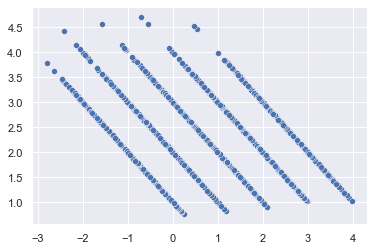

In [65]:
#13.) Also tested for normalcy here. Again, not a necessary 
# condition to be met for a classification. At the time we 
# were testing our regression model.

sns.set()

pred_val = model.fittedvalues.copy()
true_val = df['crash_severity_id'].values.copy()
residual = true_val - pred_val

ax = sns.scatterplot(x=residual, y=pred_val)

0.8117033686014471

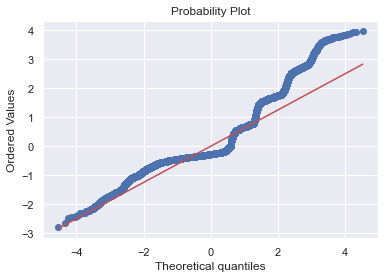

In [66]:
#14.) Similar to our above graph, a view of our then current model's normalcy. 
# At the time we were testing our regression model.

import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

In [67]:
#15.) One more normalcy test for our previous regression 
# model! Later discovered this is included in the OLS results.

from scipy import stats

stats.jarque_bera(df_test)

#output is less than .05, so this is not a normal distribution (can also conclude that from above graphs)

Jarque_beraResult(statistic=445275173.0537588, pvalue=0.0)

In [25]:
#16.) Randomly shrunk our ~242,000-entry dataset down to about 75,000 (for computing power restraints).

df_test = df_test.sample(frac=.3)

In [26]:
#17.) Double-check size before breaking computer (again).

df_test.shape

(73274, 70)

In [27]:
#18.) Here we first changed the label column to a string for classification purposes. We 
# then ran our classification modeling pipeline and saved it externally. Looks like the best 
# model was a Logistic classification, just about 72% accurate

df_test['crash_severity_id'] = df_test['crash_severity_id'].astype('str')

# Modeling pipeline
model = fit_crossvalidate_clf(df_test, "crash_severity_id", 5, 2)

# Deployment pipeline
dump_pickle(model, 'best_clf_model.sav')

                   Accuracy
Logistic           0.719935
Ridge              0.719791
Voting             0.719751
HistGradient       0.719368
SVM                0.718973
XGBoost            0.718086
AdaBoost           0.717949
NeuralN            0.717274
NaiveBayes         0.716045
SGD                0.716038
Bagging            0.710975
ExtraTrees         0.707372
RandomForest       0.704950
GradBoost          0.704411
Perceptron         0.668859
KNN                0.664247
PassiveAggressive  0.578535


C:\Users\jpgra\Desktop\455\assignment1\ml-venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#19.) Unnecessary within the same session, but here we load in 
# the pickle file with the saved model.

model = load_pickle("best_clf_model.sav")

In [ ]:
#20.) Finally, we convert our model to an onnx file. It's necessary to change the 
# second parameter within FloatTensorType ('70' currently) to however features
# your model has.

initial_type = [('float_input', FloatTensorType([None, 70]))]
onnx = convert_sklearn(model, initial_types=initial_type)
with open("C:/Users/jpgra/Desktop/455/model.onnx", "wb") as f:
    f.write(onnx.SerializeToString())

In [ ]:
# With this, our model is fully functional within ASP.net without having to convert it to C#.
# Let's go.